Cuando hacemos modelos me gusta pensar que nos convertimos en cocineros/as: si bien seguimos una receta básica, podemos modificarla en función de nuestras necesidades. Este primer ejercicio es una muestra de ello, pues como ya se habrán dado cuenta hemos tenido que modificar algunos pasos del ejemplo que hicimos en clase la semana pasada.

No tengan miedo modificar los pasos que aquí se indican, pues finalmente ustedes pueden añadirle o quitarle 'ingredientes' en función de lo que les parezca más fácil o de aquello que crean les dará mejores resultados. En estos cuadernos sólo busco organizar un flujo de trabajo que recomiendo seguir para obtener un modelo OLS.

# 1. Importación de librerías

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor #para calcular el VIF
import statsmodels.api as sm #para modelos
import scipy.stats as stats #para calcular los residuos estandarizados
from scipy.stats import pearsonr #para calcular correlaciones
from sklearn.metrics import mean_squared_error #para calcular el MSE
import matplotlib.pyplot as plt #para gráficos
import plotly.graph_objects as go #para hacer gráficos interactivos

In [2]:
bdd=pd.read_csv('rawdata/clases/habitaclia4043.csv')

# 2. Revisión de variables

Me interesa ver qué variables tengo. Casi siempre hay variables que no me sirven de nada, mi interés es quitarlas antes de ponerme a trabajar.

In [3]:
bdd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4043 entries, 0 to 4042
Columns: 204 entries, Unnamed: 0 to EPC_G_emision_2023
dtypes: float64(189), int64(1), object(14)
memory usage: 6.3+ MB


In [4]:
print(bdd.columns.tolist())

['Unnamed: 0', 'OBJECTID_1', 'codigo_inmueble1', 'Title', 'Type_build', 'Type_opera', 'Link', 'Location', 'Lat_X', 'Lon_Y', 'Climatic_Z', 'Nom_Mun', 'precio_eur', 'superficie', 'superficie_2', 'Unit_price', 'Ln_total_pr', 'Ln_unit_pr', 'numero_habitaciones', 'numero_bano', 'ratio_bano_hab', 'numero_aseo', 'ascensor', 'interac_planta', 'numero_de_piso', 'anyo_constr', 'anyo_constr_ponderad', 'antig_ponderad', 'Inverse_Age', 'Year_Before_1981', 'Year_1982_2006', 'Year_After_2007', 'superficie_terraza_m2', 'grand_terr_20m2', 'superficie_jardin_m2', 'superficie_salon', 'bool_despacho', 'bool_buhardilla', 'bool_trastero', 'bool_lavadero', 'bool_piscina_comunitaria', 'bool_jardin_comunitario', 'bool_amueblado', 'bool_ascensor', 'descripcion', 'bool_aire_acondicionado', 'bool_calefaccion', 'bool_chimenea', 'texto_destacado', 'Description', 'calificacion_consumo_letra', 'calificacion_consumo_valor', 'calificacion_emision_letra', 'calificacion_emision_valor', 'Dum_EPC', 'EPC_A_emision', 'EPC_B_

De la revisión de la lista, hay algunas que **creo** no pueden ser muy útiles. Veámoslas.

In [5]:
noimportan=bdd[['Unnamed: 0', 'OBJECTID_1', 'codigo_inmueble1', 'Title', 'Type_build', 'Type_opera', 
     'Link', 'Location', 'Lat_X', 'Lon_Y', 'Climatic_Z', 'Nom_Mun','Dum_precio']]
noimportan.head()

,Unnamed: 0,OBJECTID_1,codigo_inmueble1,Title,Type_build,Type_opera,Link,Location,Lat_X,Lon_Y,Climatic_Z,Nom_Mun,Dum_precio
0,0,1.0,2.872004e+12,Dúplex Carrer mercader. Unico!!! dúplex en co...,Multifamilia,Selling,https://www.habitaclia.com/comprar-duplex-unic...,Hospitalet de Llobregat (L´) - Collblanc,2.114740,41.375476,C2,Hospitalet de Llobregat,0.0
1,1,2.0,5.020004e+12,Piso en Granvia LH. Piso en venta con amplio...,Multifamilia,Selling,https://www.habitaclia.com/comprar-piso-en_ven...,Hospitalet de Llobregat (L´) - Granvia LH,2.132418,41.359122,C2,Hospitalet de Llobregat,0.0
2,2,3.0,8.700366e+10,Piso Carrer oriental. Todo exterior y reformado,Multifamilia,Selling,https://www.habitaclia.com/comprar-piso-todo_e...,Hospitalet de Llobregat (L´) - Can Serra,2.100272,41.369421,C2,Hospitalet de Llobregat,0.0
3,3,4.0,5.000037e+11,"Piso en Carrer garraf, 41. Piso para entrar ...",Multifamilia,Selling,https://www.habitaclia.com/comprar-piso-para_e...,Hospitalet de Llobregat (L´) - La Florida,2.114315,41.370422,C2,Hospitalet de Llobregat,1.0
4,4,5.0,5.380035e+11,Piso Carrer riera de la creu. De obra nueva a...,Multifamilia,Selling,https://www.habitaclia.com/comprar-piso-de_obr...,Hospitalet de Llobregat (L´) - Centre,2.099040,41.359801,C2,Hospitalet de Llobregat,0.0


En efecto, ninguna de ellas me brinda información importante. Las puedo eliminar.

In [6]:
bdd=bdd.drop(noimportan.columns,axis=1)

Ahora quiero ver aquellas que quedan. Si ejecutara `bdd.dtypes` tendría que ver de qué tipo es cada columna de `bdd`. Sin embargo, como son muchas columnas, no se podrán ver bien. Para solucionarlo, ejecuto este código (se le pregunté a ChatGPT como *quiero ver qué tipo de columna tengo en mi dataframe, pero son muchas columnas, ¿cómo podría hacerlo?*)

In [7]:
for columna in bdd.columns:
    tipo_de_dato = bdd[columna].dtype
    print(f"Columna '{columna}': {tipo_de_dato}")

Columna 'precio_eur': float64
Columna 'superficie': float64
Columna 'superficie_2': float64
Columna 'Unit_price': float64
Columna 'Ln_total_pr': float64
Columna 'Ln_unit_pr': float64
Columna 'numero_habitaciones': float64
Columna 'numero_bano': float64
Columna 'ratio_bano_hab': float64
Columna 'numero_aseo': float64
Columna 'ascensor': float64
Columna 'interac_planta': float64
Columna 'numero_de_piso': float64
Columna 'anyo_constr': float64
Columna 'anyo_constr_ponderad': float64
Columna 'antig_ponderad': float64
Columna 'Inverse_Age': float64
Columna 'Year_Before_1981': float64
Columna 'Year_1982_2006': float64
Columna 'Year_After_2007': float64
Columna 'superficie_terraza_m2': float64
Columna 'grand_terr_20m2': float64
Columna 'superficie_jardin_m2': float64
Columna 'superficie_salon': float64
Columna 'bool_despacho': float64
Columna 'bool_buhardilla': float64
Columna 'bool_trastero': float64
Columna 'bool_lavadero': float64
Columna 'bool_piscina_comunitaria': float64
Columna 'bool_j

Para simplificar las cosas, voy a ver qué columnas no tienen valores numéricos, pues serán las primeras a eliminar de mi dataframe.

In [8]:
# Obtener las columnas que no son numéricas
no_numericas = bdd.select_dtypes(exclude=['number']).columns
no_numericas

Index(['descripcion', 'texto_destacado', 'Description',
       'calificacion_consumo_letra', 'calificacion_emision_letra', 'persona',
       'filter_$'],
      dtype='object')

`calificacion_emision_letra` podría ser de mi interés, da información importante, pero si se dan cuenta ya tenemos `EPC_A_emision_2023`, `EPC_B_emision_2023`, `EPC_C_emision_2023`, `EPC_D_emision_2023`, `EPC_E_emision_2023`, `EPC_F_emision_2023`, `EPC_G_emision_2023`, que son el resultado de un one-hot encoding de esa columna.

También podría obtener variables binarias sobre la columna `calificacion_consumo_letra`, pero de momento no me interesa (si a ustedes sí, le pueden preguntar a ChatGPT *cómo hacer un one-hot encoding de una variable categórica en pandas*).

Ahora que ya estoy seguro de que estas variables no me aportarán mucho, las elimino.

In [9]:
bdd=bdd.drop(no_numericas, axis=1)
bdd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4043 entries, 0 to 4042
Columns: 184 entries, precio_eur to EPC_G_emision_2023
dtypes: float64(184)
memory usage: 5.7 MB


Noten que he pasado de 204 variables a 185 tras esta limpieza.

# 3. Eliminación de filas vacías

Recién ahora que he limpiado mis variables puedo quitar las filas vacías. Si lo hubiera hecho antes, podría haber eliminado filas con base en columnas que no me interesaban.

In [10]:
bdd=bdd.dropna()
bdd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3846 entries, 0 to 4042
Columns: 184 entries, precio_eur to EPC_G_emision_2023
dtypes: float64(184)
memory usage: 5.4 MB


# 4. Revisión del histograma

Podría revisar la distribución de todas mis variables con las estadísticas de Kolmogorov-Smirnov como vimos durante clase, pero al ser tantas, de momento, no me parece muy útil hacerlo.
Lo que me interesa ahora es hacer un modelo lo más rápido posible y evaluar las variables que resulten de él.

Para empezar a hacer el modelo, reviso la distribución de mi variable independiente.

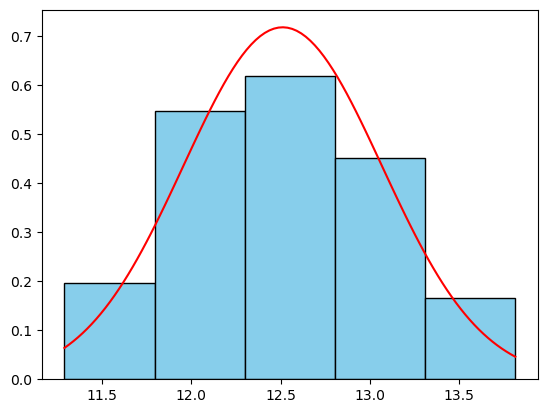

In [11]:
# Datos
data = bdd['Ln_total_pr']

# Crear histograma
plt.hist(data, bins=5, color='skyblue', edgecolor='black', density=True)

# Calcular la media y la desviación estándar para la campana de Gauss
mu = np.mean(data)
sigma = np.std(data)

# Definir el rango de valores para la campana de Gauss
x = np.linspace(min(data), max(data), 100)

# Calcular la función de densidad de probabilidad para la campana de Gauss
pdf = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Graficar la campana de Gauss
plt.plot(x, pdf, color='red')

# Mostrar el gráfico
plt.show()

Veo que sí tiene una distribución normal.

# 5. Identificación de outliers

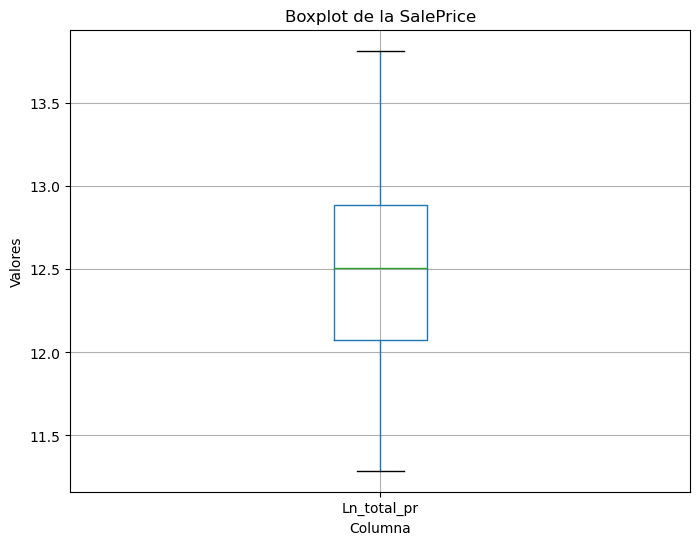

In [12]:
plt.figure(figsize=(8, 6))
bdd.boxplot(column='Ln_total_pr',whis=1.5) ## revisar 'bdd' ##
plt.title('Boxplot de la SalePrice')
plt.xlabel('Columna')
plt.ylabel('Valores')
plt.grid(True)
plt.show()

¿Por qué creen que el gráfico me sugiere que no hay outliers? ¡Porque tiene una distribución normal! Son cosas que están correlacionadas.

# 6. Identificación de variables a eliminar

Sepan que nos encontramos ante un caso de análisis atípico: como ya hemos visto en el apartado 1, tenemos **185 variables** en nuestro dataset. **¡Es un montón!** Usualmente estos análisis se suelen hacer con 10-20 variables explicativas.

Si nuestra estrategia fuera la típica, ahora podríamos pasar a realizar correlaciones para entender cómo se comportan nuestras variables. ¿Pero tiene sentido hacerlo con este caso? Yo no me creo capaz de entender una matriz de correlación de 185 x 185. Me tardaría semanas tratando de analizar todas esas relaciones. Por tanto, **nuestra estrategia debe ser distinta a la que habíamos conocido**. 

Mi punto de partida es este: como en la vida real todo está relacionado, es muy probable que esas variables, que intentan capturar una realidad, también lo estén (es decir, es muy probable que algunas expliquen lo mismo, sean redudantes); por tanto, pueden causar problemas de **multicolinealidad**. En ese sentido, creo que nuestra estrategia debería enfocarse en reducir en la medida de lo posible esa cantidad de variables.

## 6.1. Primera limpieza

Antes que nada, sólo voy a considerar a las $X$ que tengan una correlación significativa con mi $y$. O al menos se acerquen mucho: noten que en el código asumo que la correlación es significativa si es menor de 0.1 y no 0.05 como debería ser normalmente.

In [13]:
# Calcular la matriz de correlación y los p-valores
matriz_correlacion = bdd.corr() ## 'bdd' es donde están mis datos ##
matriz_p_valor = bdd.corr( ## 'bdd' es donde están mis datos ##
    method=lambda x, y: pearsonr(x, y)[1]) 

# Calcular las correlaciones entre todas las variables y la variable dependiente (SalePrice)
correlation_with_saleprice = matriz_correlacion['Ln_total_pr']
#Ojo: 'matriz_correlacion' es una variable/objeto que obtuve en el paso anterior

# Filtrar correlaciones significativas y no significativas
significant_correlations = correlation_with_saleprice[matriz_p_valor['Ln_total_pr'] < 0.1]
insignificant_correlations = correlation_with_saleprice[matriz_p_valor['Ln_total_pr'] >= 0.1]
#Ojo: 'matriz_p_valor' es una variable/objeto que obtuve en el paso anterior

# Crear DataFrames para cada tipo de correlación
significant_table = pd.DataFrame({'Correlation with Ln_total_pr': significant_correlations,
                                  'p-value': matriz_p_valor.loc[significant_correlations.index, 'Ln_total_pr']})

insignificant_table = pd.DataFrame({'Correlation with Ln_total_pr': insignificant_correlations,
                                    'p-value': matriz_p_valor.loc[insignificant_correlations.index, 'Ln_total_pr']})

# Mostrar las tablas
print("Correlaciones significativas:")
print(significant_table)
print("\nVariables incluidas:")
print(list(significant_table.index))
print("\nCorrelaciones no significativas:")
print(insignificant_table)
print("\nVariables incluidas:")
print(list(insignificant_table.index))

C:\Users\rojas\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Correlaciones significativas:
                    Correlation with Ln_total_pr       p-value
precio_eur                              0.950864  0.000000e+00
superficie                              0.703626  0.000000e+00
superficie_2                            0.588357  0.000000e+00
Unit_price                              0.761584  0.000000e+00
Ln_unit_pr                              0.777964  0.000000e+00
...                                          ...           ...
EPC_C_emision_2023                      0.044758  5.500239e-03
EPC_D_emision_2023                      0.039766  1.365036e-02
EPC_E_emision_2023                     -0.044657  5.606750e-03
EPC_F_emision_2023                     -0.063080  9.054850e-05
EPC_G_emision_2023                     -0.130510  4.442070e-16

[171 rows x 2 columns]

Variables incluidas:
['precio_eur', 'superficie', 'superficie_2', 'Unit_price', 'Ln_unit_pr', 'numero_habitaciones', 'numero_bano', 'ratio_bano_hab', 'numero_aseo', 'ascensor', 'interac_pla

Voy a definir un objeto que almacene todas estas $X$ que son significativas (sólo estoy copiando las variables que me aparecieron en la celda anterior):

In [14]:
X=bdd[['precio_eur', 'superficie', 'superficie_2', 'Unit_price', 'Ln_unit_pr', 'numero_habitaciones', 'numero_bano', 'ratio_bano_hab', 'numero_aseo', 'ascensor', 'interac_planta', 'numero_de_piso', 'anyo_constr', 'anyo_constr_ponderad', 'antig_ponderad', 'Inverse_Age', 'Year_Before_1981', 'Year_1982_2006', 'Year_After_2007', 'superficie_terraza_m2', 'grand_terr_20m2', 'superficie_salon', 'bool_despacho', 'bool_trastero', 'bool_piscina_comunitaria', 'bool_jardin_comunitario', 'bool_ascensor', 'bool_aire_acondicionado', 'bool_calefaccion', 'bool_chimenea', 'calificacion_consumo_valor', 'calificacion_emision_valor', 'Dum_EPC', 'EPC_A_emision', 'EPC_B_emision', 'EPC_C_emision', 'EPC_D_emision', 'EPC_E_emision', 'EPC_F_emision', 'EPC_G_emision', 'COD_MUN', 'radiacion_enero', 'radiacion_julio', 'POB_91', 'POB_01', 'POB_06', 'POR_01', 'LTL1991_M', 'LTL_2001', 'DLTL_MUN', 'RW', 'FLE', 'FLS', 'SUP_URB_90', 'SUP_URB_00', 'Job_ratio_01', 'Autocontencion_01', 'Nodalidad_01', 'Dist_CBD', 'Dist_CBD2', 'Dist_sub_center', 'Elevation_Mean', 'IND_pr', 'FIRE_pr', 'Div_LandUse', 'COD_SEC', 'pr_directivo', 'pr_tecnico_prof', 'pr_tecnico_apoyo', 'pr_restaur_comer', 'pr_agri_calificado', 'pr_artesano', 'pr_operador', 'pr_no_calif', 'desplaz_ponderado', 'plant_ras_pond', 'edif_ruin_pr', 'edif_malo_pr', 'edif_deficient_pr', 'Doorman_pr', 'opin_ruido_si_pr', 'opin_contam_si_pr', 'opin_calle_sucia_pr', 'opin_mala_comunic_pr', 'opin_delincuencia_pr', 'opin_falta_aseo_pr', 'local_salud_pr', 'local_edu_pr', 'local_social_pr', 'local_cult_pr', 'local_comerc_pr', 'local_oficinas_pr', 'local_industr_pr', 'local_agrar_pr', 'POB_TOTAL', 'POB_RESID', 'LOC_TOTAL', 'POR_TOTAL', 'LOC_VIV_TOTAL', 'dens_loc_100hab', 'dens_loc_sup', 'dens_pob_sup', 'estud_sin_pr', 'estud_primer_pr', 'estud_segund_pr', 'estud_tercer_pr', 'Sup_viv_sec', 'viv_ppales_pr', 'viv_no_ppales_pr', 'viv_secundarias_pr', 'viv_vacias_pr', 'viv_unifam_pr', 'viv_aptos_pr', 'resi_euro_pr', 'resi_africa_pr', 'resi_america_pr', 'resi_asia_pr', 'resi_oceania_pr', 'H_ocup_POR', 'H_loc_INE', 'H_tamaviv', 'H_ocup_POR_Xpor', 'H_loc_INE_XLOCS', 'H_tamaviv_Xvivs', 'CT_renta_alta_CPA', 'CT_renta_medb_CPA', 'Income_Household_2016', 'DP2e', 'Dens_Time_total', 'Dens_Time_total_work', 'Dens_Time_total_Nwork', 'Dens_pers_act_total', 'Dens_pers_act_working', 'Dens_pers_act_Nworking', 'Div_total_work', 'Div_act_work', 'Div_socio_work', 'Div_total_Nwork', 'Div_act_Nwork', 'Div_socio_Nwork', 'calidad_cocina', 'diseny_cocina', 'alta_calidad', 'reform_inmob', 'dum_mar_200m', 'dum_ttpp_riel_urb', 'dist_near_riel_km', 'dist_near_viappal_km', 'C_contempo', 'C_estado', 'C_armarios', 'B_contempo', 'B_estado', 'B_lavamano', 'R_contempo', 'R_estado', 'R_carpinte', 'R_singular', 'R_ventana', 'Precio_red', 'scrap_year', 'Estado_contemporaneidad_calidad', 'Ausencia_singulares_presencia_arm_cocina', 'Muestra_2023', 'EPC_A_emision_2023', 'EPC_B_emision_2023', 'EPC_C_emision_2023', 'EPC_D_emision_2023', 'EPC_E_emision_2023', 'EPC_F_emision_2023', 'EPC_G_emision_2023']]

Noten que hay algunas variables que voy a eliminar de mis $X$ por no ser importantes (o porque son lo mismo que mi $y$); es decir, se 'colaron' del procedimiento del primer apartado: `precio_eur`, `Unit_price`, `Ln_unit_pr`,`COD_MUN`, `calificacion_emision_valor`, `ascensor` (dado que es lo mismo que `bool_ascensor`). Lo mismo con todas las variables de *calidad* y *contemporaneidad* (`C_estado`, `C_armarios`, `R_estado`, etc.), dado que todas se resumen en  `Estado_contemporaneidad_calidad` y `Ausencia_singulares_presencia_arm_cocina` (si Carlos no se los ha explicado, me lo recuerdan en clase y les comento brevemente cómo se hace eso).

Y aprovecho en definir mis $y$.

In [15]:
X=X.drop(['COD_MUN','precio_eur','Unit_price','Ln_unit_pr',
            'calificacion_emision_valor','ascensor','C_contempo', 'C_estado', 'C_armarios', 'B_contempo', 
            'B_estado', 'B_lavamano', 'R_contempo', 'R_estado', 'R_carpinte', 'R_singular', 
            'R_ventana', 'Precio_red', 'scrap_year'],axis=1)
y = bdd['Ln_total_pr']

## 6.2. Segunda limpieza

Ahora sí. Aquí viene lo interesante. 

Yo creo que podríamos empezar calculando estos datasets:
1. Correlación entre todas mis $X$
2. Correlación de todas las $X$ con $y$ 
3. VIF de mis $X$

Mi finalidad es obtener un cuarto dataset:

4. Lista de nuevas variables sin autocorrelación

Por tanto, podría definir estos pasos:
1. Ordenar los VIF de mayor a menor (dataset 3).
2. Si una variable tiene un VIF **inferior** a 5 (dataset 3), ingresarla a una lista de nuevas variables (dataset 4).
3. Si una variable tiene VIF **superior** a 5 (dataset 3), revisar las correlaciones entre ellas (dataset 1) y armar una *lista provisional* con todas aquellas variables con las que tiene una correlación significativa o muy cercana a la significancia (p-valor<0.1). Este valor lo pongo de manera arbitraria para ser más flexible en los resultados.
3. Sobre esa *lista provisional*, eliminar a aquellas que tengan un VIF inferior a 18 (revisando el dataset 3).
4. Sobre la misma *lista provisional*, elegir únicamente a la variable con la mayor correlación con $y$ (dataset 2) para ingresarla a la lista de nuevas variables (dataset 4).

Tras haberle preguntado a ChatGPT que necesito seguir los cinco pasos, obtengo este código:

In [16]:
# 1. Calcular correlación entre X (dataset 1) y sus p-valores
correlation_matrix = X.corr()
p_values = X.apply(lambda x: pd.Series(pearsonr(x, y)), axis=0).transpose()[1]

# 2. Calcular correlación de todas las X con y (dataset 2)
correlation_with_y = X.apply(lambda x: pearsonr(x, y)[0])

# 3. Calcular VIF de mis X (dataset 3)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 4. Inicializar lista de nuevas variables (dataset 4)
new_variables = []

# 5. Ordenar los VIF de mayor a menor
vif_data = vif_data.sort_values(by='VIF', ascending=False)

# 6. Recorrer las variables y aplicar las reglas
for index, row in vif_data.iterrows():
    if row['VIF'] < 18:
        new_variables.append(row['feature'])
    else:
        correlated_features = correlation_matrix.loc[row['feature'], (correlation_matrix[row['feature']] > 0.1) & (p_values < 0.1)].index.tolist()
        high_vif_correlated_features = [feature for feature in correlated_features if vif_data.loc[vif_data['feature'] == feature, 'VIF'].values[0] >= 5]
        if high_vif_correlated_features:
            max_corr_with_y_feature = max(high_vif_correlated_features, key=lambda x: correlation_with_y[x])
            new_variables.append(max_corr_with_y_feature)

# 7. Crear dataframe final con las nuevas variables (dataset 4)
new_variables_df = pd.DataFrame(new_variables, columns=['new_variables'])
new_variables_df.drop_duplicates(inplace=True)

print(new_variables_df['new_variables'].tolist())

C:\Users\rojas\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


['pr_tecnico_prof', 'CT_renta_alta_CPA', 'anyo_constr_ponderad', 'Income_Household_2016', 'Year_1982_2006', 'pr_tecnico_apoyo', 'viv_no_ppales_pr', 'opin_falta_aseo_pr', 'Dum_EPC', 'superficie', 'numero_bano', 'dens_loc_sup', 'bool_ascensor', 'Year_After_2007', 'EPC_E_emision_2023', 'EPC_E_emision', 'H_tamaviv_Xvivs', 'resi_america_pr', 'viv_vacias_pr', 'estud_tercer_pr', 'viv_aptos_pr', 'H_ocup_POR_Xpor', 'H_loc_INE_XLOCS', 'superficie_2', 'Dist_CBD', 'local_industr_pr', 'opin_delincuencia_pr', 'opin_calle_sucia_pr', 'Div_socio_work', 'opin_contam_si_pr', 'opin_ruido_si_pr', 'dens_pob_sup', 'interac_planta', 'calificacion_consumo_valor', 'ratio_bano_hab', 'opin_mala_comunic_pr', 'numero_habitaciones', 'dist_near_riel_km', 'dum_mar_200m', 'edif_malo_pr', 'plant_ras_pond', 'dist_near_viappal_km', 'EPC_G_emision_2023', 'pr_agri_calificado', 'local_salud_pr', 'H_loc_INE', 'EPC_B_emision_2023', 'EPC_A_emision_2023', 'edif_deficient_pr', 'edif_ruin_pr', 'superficie_terraza_m2', 'grand_terr_

Pueden copiar la advertencia (eso que aparece en rojo) y copiársela a ChatGPT (denle contexto de qué están elaborando) y verán que no se trata de nada malo.

In [17]:
len(new_variables_df)

79

In [18]:
new_variables_df.head()

,new_variables
0,pr_tecnico_prof
8,CT_renta_alta_CPA
16,anyo_constr_ponderad
23,Income_Household_2016
25,Year_1982_2006


Ahora creo un nuevo objeto que tenga estas $X$ con un buen VIF (sólo estoy seleccionando el resultado de arriba y pegándolo).

In [19]:
X_buenvif=bdd[['pr_tecnico_prof', 'anyo_constr_ponderad', 'pr_tecnico_apoyo', 'Income_Household_2016', 'CT_renta_alta_CPA', 'opin_falta_aseo_pr', 'Year_1982_2006', 'superficie', 'Dum_EPC', 'viv_no_ppales_pr', 'numero_bano', 'dens_loc_sup', 'bool_ascensor', 'Year_After_2007', 'EPC_E_emision_2023', 'EPC_E_emision', 'H_tamaviv_Xvivs', 'resi_america_pr', 'viv_vacias_pr', 'estud_tercer_pr', 'viv_aptos_pr', 'H_ocup_POR_Xpor', 'H_loc_INE_XLOCS', 'superficie_2', 'Dist_CBD', 'local_industr_pr', 'opin_delincuencia_pr', 'opin_calle_sucia_pr', 'Div_socio_work', 'opin_contam_si_pr', 'opin_ruido_si_pr', 'dens_pob_sup', 'interac_planta', 'calificacion_consumo_valor', 'ratio_bano_hab', 'opin_mala_comunic_pr', 'numero_habitaciones', 'dist_near_riel_km', 'dum_mar_200m', 'edif_malo_pr', 'plant_ras_pond', 'dist_near_viappal_km', 'EPC_G_emision_2023', 'pr_agri_calificado', 'local_salud_pr', 'H_loc_INE', 'EPC_B_emision_2023', 'EPC_A_emision_2023', 'edif_deficient_pr', 'edif_ruin_pr', 'superficie_terraza_m2', 'grand_terr_20m2', 'numero_de_piso', 'Inverse_Age', 'dum_ttpp_riel_urb', 'local_edu_pr', 'local_cult_pr', 'EPC_F_emision_2023', 'local_social_pr', 'EPC_C_emision_2023', 'EPC_D_emision_2023', 'Doorman_pr', 'local_agrar_pr', 'Estado_contemporaneidad_calidad', 'bool_calefaccion', 'bool_piscina_comunitaria', 'bool_aire_acondicionado', 'bool_jardin_comunitario', 'superficie_salon', 'reform_inmob', 'calidad_cocina', 'anyo_constr', 'bool_trastero', 'numero_aseo', 'Ausencia_singulares_presencia_arm_cocina', 'alta_calidad', 'bool_despacho', 'diseny_cocina', 'bool_chimenea']]

**Cuestión importante: ¿Por qué considero eliminar aquellas variables con un VIF menor a 9 y no a 3?** Por experiencia. Normalmente las variables con un VIF muy elevado (>50) también elevan el VIF de otras; por tanto, al quitarlas, algunas que podrían haber tenido un VIF de 9 (escojo el número sólo por ser múltiplo de 3) ahora podrían bajar a 2 o a 3.

Sin embargo, la tarea no está terminada: tras haber hecho la segunda limpieza, aún es posible que las variables que queden tengan una correlación entre ellas. 

Esto porque el VIF está condicionado a las variables con las que comparas una variable en específico. Si ahora cada variable las comparas con otro conjunto, su VIF puede modificarse (usualmente disminuyendo, pero no necesariamente).

In [20]:
# Calcular el VIF para cada variable independiente
vif = pd.DataFrame()
vif["Variable"] = X_buenvif.columns ## revisar 'X' ##
vif["VIF"] = [variance_inflation_factor(X_buenvif.values, i) ## revisar 'X' ##
              for i in range(X_buenvif.shape[1])] ## revisar 'X' ##

# Imprimir el resultado
print(vif)

                                    Variable          VIF
0                            pr_tecnico_prof   563.165855
1                       anyo_constr_ponderad  1261.034964
2                           pr_tecnico_apoyo   117.089676
3                      Income_Household_2016   154.170973
4                          CT_renta_alta_CPA    39.919621
..                                       ...          ...
74  Ausencia_singulares_presencia_arm_cocina     1.137811
75                              alta_calidad     1.393963
76                             bool_despacho     1.178533
77                             diseny_cocina     1.148659
78                             bool_chimenea     1.111554

[79 rows x 2 columns]


Ordenamos de mayor a menor.

In [21]:
vif = vif.sort_values(by='VIF', ascending=False)
print(vif)

                                    Variable          VIF
1                       anyo_constr_ponderad  1261.034964
20                              viv_aptos_pr   916.515571
19                           estud_tercer_pr   589.613728
0                            pr_tecnico_prof   563.165855
28                            Div_socio_work   365.657165
..                                       ...          ...
76                             bool_despacho     1.178533
59                        EPC_C_emision_2023     1.161098
77                             diseny_cocina     1.148659
74  Ausencia_singulares_presencia_arm_cocina     1.137811
78                             bool_chimenea     1.111554

[79 rows x 2 columns]


## 6.3. Tercera limpieza

Lo que necesitamos ahora es añadir un paso a los cinco previamente definidos:

6. Calcular el VIF sobre la nueva lista de variables, pero esta vez revisar que no tenemos variables con VIF por encima de 9. Si no hubiera, entregar la lista como "lista_final". Si sí lo hubiera, iterar los pasos anteriores.

Noten que ahora nuestro umbral ya es 6, porque la cantidad de variables con un VIF muy alto es menor que al inicio. Es parte de mi *receta*. Ustedes pueden probar con otros valores. 

In [22]:
# Inicializar lista de variables con VIF > 9
high_vif_variables = []

# Iterar hasta que no haya variables con VIF > 9 o no haya nuevas variables para agregar
while True:
    # Calcular VIF sobre la lista actual de variables
    vif_data_new = pd.DataFrame()
    vif_data_new["feature"] = X_buenvif.columns
    vif_data_new["VIF"] = [variance_inflation_factor(bdd[X_buenvif.columns].values, i) for i in range(len(X_buenvif.columns))]
    
    # Verificar si hay variables con VIF > 9
    high_vif_variables = vif_data_new[vif_data_new['VIF'] > 9]['feature'].tolist()
    
    # Si no hay variables con VIF > 9, salir del bucle
    if not high_vif_variables:
        break
    
    # Depurar la lista de variables eliminando aquellas con VIF > 9
    X_buenvif = X_buenvif.drop(columns=high_vif_variables)
    
# Finalmente, obtener la lista final de variables
lista_final = X_buenvif.columns.tolist()
print(lista_final)

['opin_falta_aseo_pr', 'Year_1982_2006', 'Year_After_2007', 'EPC_E_emision_2023', 'EPC_E_emision', 'H_loc_INE_XLOCS', 'Dist_CBD', 'local_industr_pr', 'interac_planta', 'calificacion_consumo_valor', 'opin_mala_comunic_pr', 'dum_mar_200m', 'edif_malo_pr', 'dist_near_viappal_km', 'EPC_G_emision_2023', 'pr_agri_calificado', 'local_salud_pr', 'EPC_B_emision_2023', 'EPC_A_emision_2023', 'edif_ruin_pr', 'superficie_terraza_m2', 'grand_terr_20m2', 'Inverse_Age', 'dum_ttpp_riel_urb', 'local_edu_pr', 'local_cult_pr', 'EPC_F_emision_2023', 'local_social_pr', 'EPC_C_emision_2023', 'EPC_D_emision_2023', 'Doorman_pr', 'local_agrar_pr', 'Estado_contemporaneidad_calidad', 'bool_calefaccion', 'bool_piscina_comunitaria', 'bool_aire_acondicionado', 'bool_jardin_comunitario', 'superficie_salon', 'reform_inmob', 'calidad_cocina', 'anyo_constr', 'bool_trastero', 'numero_aseo', 'Ausencia_singulares_presencia_arm_cocina', 'alta_calidad', 'bool_despacho', 'diseny_cocina', 'bool_chimenea']


In [ ]:
X_buenvif2=X_buenvif[['opin_falta_aseo_pr', 'Year_1982_2006', 'Year_After_2007', 'EPC_E_emision_2023', 'EPC_E_emision', 'H_loc_INE_XLOCS', 'Dist_CBD', 'local_industr_pr', 'interac_planta', 'calificacion_consumo_valor', 'opin_mala_comunic_pr', 'dum_mar_200m', 'edif_malo_pr', 'dist_near_viappal_km', 'EPC_G_emision_2023', 'pr_agri_calificado', 'local_salud_pr', 'EPC_B_emision_2023', 'EPC_A_emision_2023', 'edif_ruin_pr', 'superficie_terraza_m2', 'grand_terr_20m2', 'Inverse_Age', 'dum_ttpp_riel_urb', 'local_edu_pr', 'local_cult_pr', 'EPC_F_emision_2023', 'local_social_pr', 'EPC_C_emision_2023', 'EPC_D_emision_2023', 'Doorman_pr', 'local_agrar_pr', 'Estado_contemporaneidad_calidad', 'bool_calefaccion', 'bool_piscina_comunitaria', 'bool_aire_acondicionado', 'bool_jardin_comunitario', 'superficie_salon', 'reform_inmob', 'calidad_cocina', 'anyo_constr', 'bool_trastero', 'numero_aseo', 'Ausencia_singulares_presencia_arm_cocina', 'alta_calidad', 'bool_despacho', 'diseny_cocina', 'bool_chimenea']]

# Calcular el VIF para cada variable independiente
vif = pd.DataFrame()
vif["Variable"] = X_buenvif2.columns ## revisar 'X' ##
vif["VIF"] = [variance_inflation_factor(X_buenvif2.values, i) ## revisar 'X' ##
              for i in range(X_buenvif2.shape[1])] ## revisar 'X' ##

# Imprimir el resultado
print(vif)

# 7. Elaboración del modelo de pasos sucesivos

## 7.1. $p$ valores

Los pasos sucesivos (*stepwises*) crean varias combinaciones de variables hasta encontrar una estadística que tu definas: en este caso, hasta encontrar un modelo con variables cuyos p-valores sean menores a 0.2 (una vez más, estoy siendo flexible con estos umbrales, ustedes pueden ajustar el valor). 

Hay dos maneras de hacer un paso sucesivo: hacia adelante o *forward* (empieza con una variable y va añadiendo más), y hacia atrás o *backward* (empieza con todas las variables y las va quitando hasta conseguir la estadística que tú le pediste). 

Lo primero que necesitamos es instalar una librería llamada `stepwise-regression` (no la tienen instalada por defecto) con `pip`. Este paso sólo se debe hacer una vez.

In [ ]:
pip install stepwise-regression

En este caso, yo lo definiré hacia atrás (porque está pensada para tener la mayor cantidad de variables posibles), pero si quisiera hacerlo al revés sólo deben cambiar `backward_regression` por `forward regression`.

In [ ]:
from stepwise_regression import step_reg

backselect=step_reg.backward_regression(X_buenvif2,y,0.2,verbose=False)
print(len(backselect))
print(backselect)

Lo que hace `step_reg` es devolver una lista de variables que cumple con la condición pedida: que su combinación entregue un modelo con p-valores menores a 0.2. Ojo: sólo se está centrando en los p-valores de las variables, no en el R$^2$ del modelo ni en niguna otra estadística.

Ahora podemos crear un objeto llamado `X_mejor` que tome en cuenta sólo a esas variables para crear un modelo y ver su rendimiento.

In [ ]:
X_mejor=X_buenvif2[['opin_falta_aseo_pr', 'Year_1982_2006', 'Year_After_2007', 'H_loc_INE_XLOCS', 'Dist_CBD', 'local_industr_pr', 'interac_planta', 'calificacion_consumo_valor', 'opin_mala_comunic_pr', 'dum_mar_200m', 'edif_malo_pr', 'dist_near_viappal_km', 'EPC_G_emision_2023', 'pr_agri_calificado', 'EPC_B_emision_2023', 'EPC_A_emision_2023', 'edif_ruin_pr', 'superficie_terraza_m2', 'Inverse_Age', 'local_edu_pr', 'local_cult_pr', 'EPC_F_emision_2023', 'EPC_C_emision_2023', 'EPC_D_emision_2023', 'Doorman_pr', 'local_agrar_pr', 'Estado_contemporaneidad_calidad', 'bool_calefaccion', 'bool_piscina_comunitaria', 'bool_aire_acondicionado', 'bool_jardin_comunitario', 'reform_inmob', 'calidad_cocina', 'anyo_constr', 'bool_trastero', 'numero_aseo', 'Ausencia_singulares_presencia_arm_cocina', 'alta_calidad', 'bool_despacho', 'diseny_cocina', 'bool_chimenea']]
# Agregar una constante (Beta) a la matriz X para el término de intercepción del modelo
X_mejor = sm.add_constant(X_mejor)

# Crear el modelo de regresión lineal
ols = sm.OLS(y, X_mejor) #noten que seguimos pidiendole que use 'sm' 

# Ajustar el modelo a los datos
results = ols.fit()

# Imprimir el resumen del modelo
print(results.summary())

Me parece un modelo aceptable. No necesariamente todas las variables de un modelo de precios hedónicos deben ser significativas, aunque sólo podamos hacer aseveraciones sobre aquellas que sí. 

Por si las dudas reviso el VIF. Para eso necesario primero quitar la constante.

In [ ]:
X_mejor=X_mejor.drop(['const'],axis=1)

# Calcular el VIF para cada variable independiente
vif = pd.DataFrame()
vif["Variable"] = X_mejor.columns ## revisar 'X' ##
vif["VIF"] = [variance_inflation_factor(X_mejor.values, i) ## revisar 'X' ##
              for i in range(X_mejor.shape[1])] ## revisar 'X' ##

# Imprimir el resultado
print(vif)

En general, un buen rendimiento también. Como les comenté en clase: **Si bien puede entenderse como ideal que el VIF de mis variables sea menor o igual a 3, si algunas no cumplen con eso no es el fin del mundo**. Sólo hay que reportarlo.

### 7.1.1. Revisión de supuestos

In [ ]:
# Calcular los residuos del modelo
residuos = results.resid # 'results' es como llamé al objeto que contiene los resultados de mi modelo 
                         # en la celda 29
# Graficar los residuos
plt.figure(figsize=(8, 6))
plt.scatter(results.fittedvalues, residuos) # le indico que trabaje sobre 'results'
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de residuos')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(residuos, ## revisar 'residuos' ## 
         bins=30, density=True, alpha=0.6, color='b')
plt.title('Histograma de los errores')
plt.xlabel('Errores')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

Una manera de corroborar si los residuos realmente tienen una distribución normal, es aplicando las pruebas de Shapiro-Wilk y Kolmogorov-Smirnov. Si el p-valor es menor a 0.05, confirmamos que tenemos una distribución normal.

In [ ]:
# Prueba de Shapiro-Wilk
shapiro_test = stats.shapiro(residuos)
print("Prueba de Shapiro-Wilk:")
print("Estadística de prueba:", shapiro_test.statistic)
print("Valor p:", shapiro_test.pvalue)

# Prueba de Kolmogorov-Smirnov
kolmogorov_test = stats.kstest(residuos, 'norm')
print("\nPrueba de Kolmogorov-Smirnov:")
print("Estadística de prueba:", kolmogorov_test.statistic)
print("Valor p:", kolmogorov_test.pvalue)

In [ ]:
# Calcular los residuos estandarizados
residuos_estandarizados = results.get_influence().resid_studentized_internal ## revisar 'mod_antiguo' ##

# Calcular la distribución acumulativa de los residuos estandarizados
distribucion_acumulativa = stats.probplot(residuos_estandarizados, dist="norm", plot=plt)

# Personalizar el gráfico
plt.title('Gráfico P-P normal de residuos estandarizados')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los residuos estandarizados')
plt.grid(True)
plt.show()

Una vez más, confirmo que se trata de un buen modelo.

### 7.1.2. Afinación del modelo

Si quisieran mejorar el modelo para que tenga un R$^2$ mayor, pueden ir añadiendo o quitando variables manualmente.

Por ejemplo, yo revisaría todas las variables que resultaron significativas con $y$, que ya hemos obtenido en el apartado 6.1.

Estas variables y su respectiva correlación se guardaron en el objeto `significant_table`. Por tanto, puedo exportarlo a Excel y revisarlo paciencia.

In [ ]:
significant_table.to_excel('data/clases/significant_table.xlsx')

De su revisión, yo veo que `Job_ratio_01` y `FIRE_pr` son variables que tienen una correlación significativa y fuerte (>0.50). Por tanto, probaría con ingresarla al modelo. Dado que ambas variables están en el dataframe original (`bdd`), primero creo un nuevo dataframe que las contenga.

In [ ]:
adicional=bdd[['Job_ratio_01','FIRE_pr']]

Y la concateno con `X_mejor`, que es el dataframe que usé para mi modelo.

In [ ]:
# Concatenar a lo largo de las columnas (uno al lado del otro)
X_mejor2 = pd.concat([X_mejor, adicional], axis=1)
print(X_mejor2.columns.tolist())

Revisando esta lista me doy cuenta que tengo `Inverse_Age` y `anyo_constr`, que pese a no tener un VIF alto cuentan lo mismo, por tanto eliminaré aquella que en el modelo mostró un p-valor mayor.

In [ ]:
X_mejor2 = X_mejor2.drop(['anyo_constr'],axis=1)
print(X_mejor2.columns.tolist())

Ahora veamos el modelo.

In [ ]:
#No necesito agregar una constante porque ya veo en el resultado anterior que está incluida

# Crear el modelo de regresión lineal
ols2 = sm.OLS(y, X_mejor2) #noten que seguimos pidiendole que use 'sm' 

# Ajustar el modelo a los datos
results2 = ols2.fit()

# Imprimir el resumen del modelo
print(results2.summary())

En este caso el modelo mejora ligeramente por ser pocas las variables que hemos manipulado. Pero ya será trabajo de ustedes jugar con más variables dependiendo de su análisis sobre la correlación con $y$.

**Aquí ya tiene sentido que hagas un gráfico de correlación con estas variables**.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pandas as pd

# Calcular la matriz de correlación
correlation_matrix = X_mejor2.corr()

# Crear una máscara para las correlaciones significativas (p < 0.05)
mask = np.abs(correlation_matrix) > 0.5  # Cambia el umbral según tu criterio

# Crear un mapa de calor con seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, cmap='viridis', annot=False, square=True)

# Marcar correlaciones significativas con "X"
for i in range(len(correlation_matrix)):
    for j in range(len(correlation_matrix)):
        if i < j and mask.iloc[i, j]:  # Comprobamos la máscara en el DataFrame
            plt.text(j + 0.5, i + 0.5, 'X', ha='center', va='center', color='black')

plt.title('Matriz de correlación')
plt.show()

## 7.2. R$^2$

Otra manera de hacer los pasos sucesivos es pedirle a la computadora que busque aquella combinación de variables que de el R$^2$ más alto posible. Para ello es necesario usar otra librería, que también necesitan descargar una sola vez: `mlxtend`.

In [ ]:
pip install mlxtend

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

# Inicializa el selector de características stepwise forward
sfs = SFS(LinearRegression(), k_features='best',forward=True, #si quieren el metodo backward colocan forward=False
           floating=False, scoring='r2',cv=2)

# Encuentra el mejor conjunto de características
sfs = sfs.fit(X_buenvif2, y) ## noten que le pido que se fije en 'X_sig' ##

# Muestra los resultados
print('Mejor conjunto de características:')
print(sfs.k_feature_names_)
print('R^2:', sfs.k_score_)

Ahora creamos un objeto que tome en encuenta esas variables que nos indica el resultado y corremos el modelo para ver qué características tiene.

In [ ]:
X_mejor3=bdd[['opin_falta_aseo_pr', 'Year_1982_2006', 'Year_After_2007', 'EPC_E_emision_2023', 'H_loc_INE_XLOCS', 'Dist_CBD', 'local_industr_pr', 'interac_planta', 'edif_malo_pr', 'pr_agri_calificado', 'EPC_B_emision_2023', 'EPC_A_emision_2023', 'superficie_terraza_m2', 'local_cult_pr', 'EPC_C_emision_2023', 'EPC_D_emision_2023', 'Doorman_pr', 'local_agrar_pr', 'Estado_contemporaneidad_calidad', 'bool_calefaccion', 'bool_piscina_comunitaria', 'bool_aire_acondicionado', 'bool_jardin_comunitario', 'reform_inmob', 'calidad_cocina', 'bool_trastero', 'numero_aseo', 'bool_despacho', 'diseny_cocina', 'bool_chimenea']]

##Aquí sí es necesario añadir una constante
X_mejor3=sm.add_constant(X_mejor3)

# Crear el modelo de regresión lineal
ols3 = sm.OLS(y, X_mejor3) #noten que seguimos pidiendole que use 'sm' 

# Ajustar el modelo a los datos
results3 = ols3.fit()

# Imprimir el resumen del modelo
print(results3.summary())

Ahora vemos los gráficos para corroborar los supuestos.

In [ ]:
# Calcular los residuos del modelo
residuos3 = results3.resid # 'results' es como llamé al objeto que contiene los resultados de mi modelo 
                         # en la celda 29
# Graficar los residuos
plt.figure(figsize=(8, 6))
plt.scatter(results.fittedvalues, residuos) # le indico que trabaje sobre 'results'
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de residuos')
plt.xlabel('Valores ajustados')
plt.ylabel('Residuos')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(residuos3, ## revisar 'residuos' ## 
         bins=30, density=True, alpha=0.6, color='b')
plt.title('Histograma de los errores')
plt.xlabel('Errores')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

In [ ]:
# Calcular los residuos estandarizados
residuos_estandarizados = results3.get_influence().resid_studentized_internal ## revisar 'mod_antiguo' ##

# Calcular la distribución acumulativa de los residuos estandarizados
distribucion_acumulativa = stats.probplot(residuos_estandarizados, dist="norm", plot=plt)

# Personalizar el gráfico
plt.title('Gráfico P-P normal de residuos estandarizados')
plt.xlabel('Cuantiles teóricos')
plt.ylabel('Cuantiles de los residuos estandarizados')
plt.grid(True)
plt.show()

Por la revisión de supuestos también veo que es un buen modelo. Si esta versión les convence más, podrían una vez más revisar las correlaciones (que ya he mostrado como exportar a Excel en el apartado 7.1) para ver qué variables pueden añadir manualmente a este modelo base. 